In [2]:
import os
import sys
from statistics import mean
from turtle import color
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
%run utils.ipynb

In [5]:
#Loading Data
df = pd.read_csv('room_occupancy.csv',index_col='rentaldate').drop('Unnamed: 0', axis=1)
df.head()
df.tail()

,occupancy
rentaldate,
2022-05-27,28.4375
2022-05-28,28.7500
2022-05-29,23.4375
2022-05-30,23.4375
2022-05-31,22.5000


In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
#check for data stationary 
df.apply(adfuller_test)

ADF Test Statistic : -3.799270030747604
p-value : 0.0029147923694822545
#Lags Used : 22
Number of Observations Used : 1909
Null hypothesis is rejected. Series is stationary.


occupancy    None
dtype: object

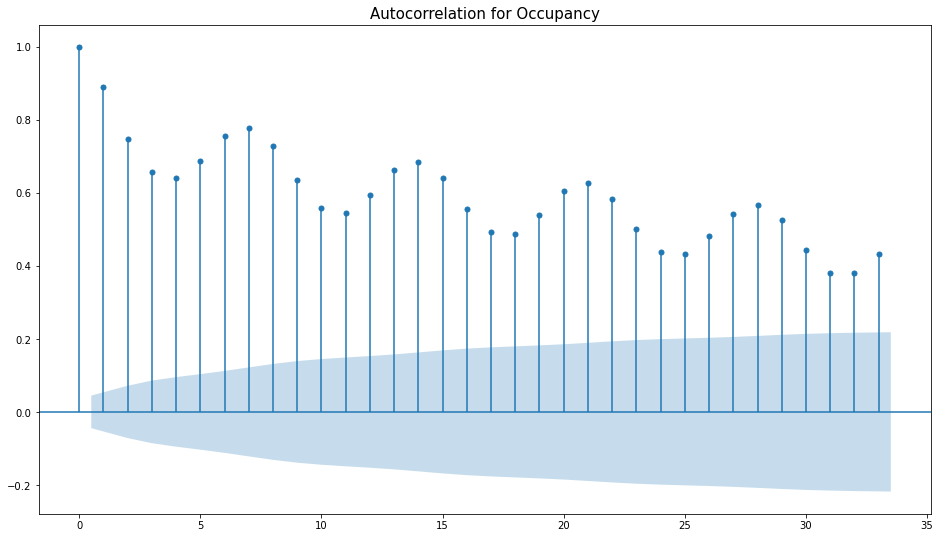

In [8]:
#Autocorrelation plot
fig, ax = plt.subplots(figsize=(16,9))
plot_acf(df.resample('D')['occupancy'].sum(), ax=ax)
plt.title('Autocorrelation for Occupancy', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

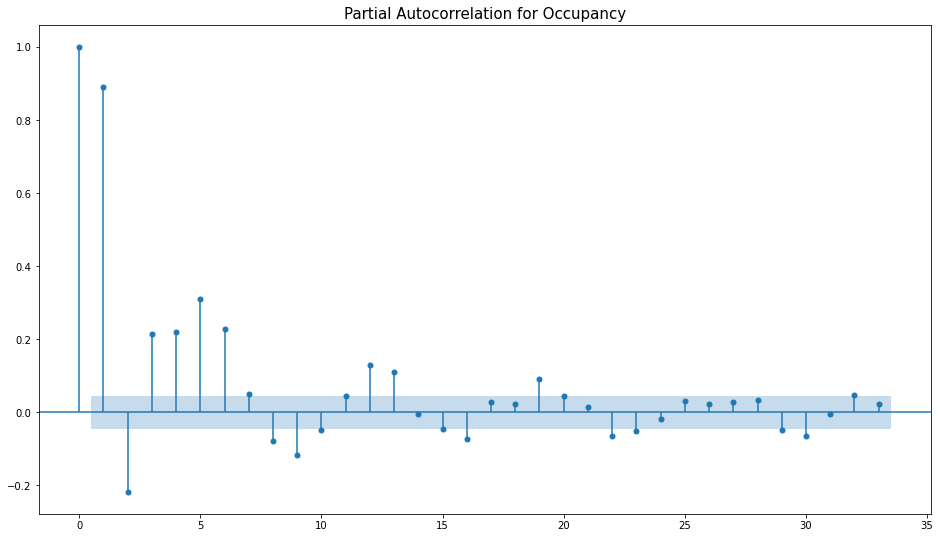

In [9]:
#Partial Autocorrelation 
fig, ax = plt.subplots(figsize=(16,9))
plot_pacf(df.resample('D')['occupancy'].sum(), ax=ax)
plt.title('Partial Autocorrelation for Occupancy', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [10]:
#Spliting in train/test
df_train = df.loc[(df.index.year >= 2017) & (df.index.year != 2022),:]
df_test = df.loc[df.index.year == 2022,:]

In [14]:
m = ARIMA(df_train.occupancy,(7,1,0))
model = m.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.occupancy   No. Observations:                 1780
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -4678.563
Method:                       css-mle   S.D. of innovations              3.351
Date:                Sat, 06 Aug 2022   AIC                           9375.126
Time:                        15:03:15   BIC                           9424.485
Sample:                    02-16-2017   HQIC                          9393.357
                         - 12-31-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0101      0.037      0.277      0.782      -0.062       0.082
ar.L1.D.occupancy    -0.0262      0.024     -1.106      0.269      -0.073       0.020
ar.L2.D.occupancy    -0.3745      0.024    -15.833      0.000      -0.421      -0.328
ar.L3.D.occupancy    -0.2554      0.025    -10.311      0.000      -0.304      -0.207
ar.L4.D.occupancy    -0.3144      0.024    -12.883      0.000      -0.362      -0.267
ar.L5.D.occupancy    -0.2065      0.025     -8.333      0.000      -0.255      -0.158
ar.L6.D.occupancy    -0.0483      0.024     -2.043      0.041      -0.095      -0.002
ar.L7.D.occupancy     0.0572      0.024      2.414      0.016       0.011       0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6985           -0.8735j            1.1184           -0.1426
AR.2            0.6985           +0.8735j            1.1184            0.1426
AR.3           -0.3461           -1.3104j            1.3554           -0.2911
AR.4           -0.3461           +1.3104j            1.3554            0.2911
AR.5           -1.4142           -0.7512j            1.6014           -0.4223
AR.6           -1.4142           +0.7512j            1.6014            0.4223
AR.7            2.9693           -0.0000j            2.9693           -0.0000
-----------------------------------------------------------------------------
"""

In [17]:
fc,se,conf = model.forecast(len(df_test), alpha = 0.05)

fc_series = pd.Series(fc,index=df_test.index)
lower_series = pd.Series(conf[:, 0],index=df_test.index)
upper_series = pd.Series(conf[:, 1],index=df_test.index)

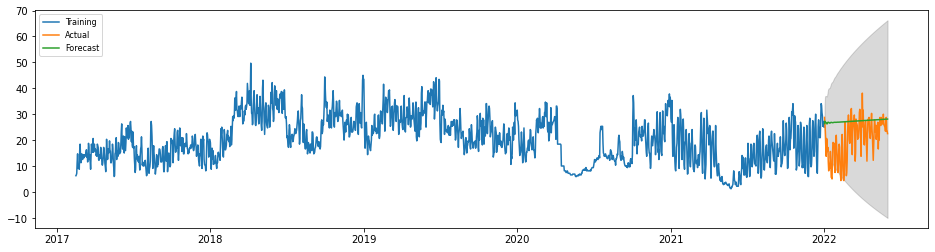

In [18]:
#visulzation
plt.figure(figsize=(16,4))
plt.plot(df_train,label ='Training')
plt.plot(df_test, label ='Actual')
plt.plot(fc_series,label = 'Forecast')
plt.fill_between(lower_series.index,lower_series,upper_series,color='k',alpha=.15)
plt.legend(loc='upper left', fontsize=8)

In [19]:
#Performance Metrics
evaluate(fc,df_test.occupancy)

{'MAE': 7.5232516337294495,
 'MAPE': 0.27721802537597257,
 'MSE': 97.67466528804206,
 'RMSE': 9.883049392168495,
 'R2': -495.9011617959881}